In [67]:
## imports
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
import scipy.stats as stats

In [2]:
## Load data
filepath = "../eewimmer/flavors_of_cacao.csv"
chocolate = pd.read_csv(filepath)
chocolate.head()

,Company \n(Maker-if known),Specific Bean Origin\nor Bar Name,REF,Review\nDate,Cocoa\nPercent,Company\nLocation,Rating,Bean\nType,Broad Bean\nOrigin
0,A. Morin,Agua Grande,1876,2016,63%,France,3.75,,Sao Tome
1,A. Morin,Kpime,1676,2015,70%,France,2.75,,Togo
2,A. Morin,Atsane,1676,2015,70%,France,3.00,,Togo
3,A. Morin,Akata,1680,2015,70%,France,3.50,,Togo
4,A. Morin,Quilla,1704,2015,70%,France,3.50,,Peru


In [3]:
chocolate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1795 entries, 0 to 1794
Data columns (total 9 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Company 
(Maker-if known)         1795 non-null   object 
 1   Specific Bean Origin
or Bar Name  1795 non-null   object 
 2   REF                               1795 non-null   int64  
 3   Review
Date                       1795 non-null   int64  
 4   Cocoa
Percent                     1795 non-null   object 
 5   Company
Location                  1795 non-null   object 
 6   Rating                            1795 non-null   float64
 7   Bean
Type                         1794 non-null   object 
 8   Broad Bean
Origin                 1794 non-null   object 
dtypes: float64(1), int64(2), object(6)
memory usage: 126.3+ KB


In [6]:
#Rename column headers
chocolate.columns = [
    'company_maker',
    'specific_bean_origin_or_bar_name',
    'ref',
    'review_date',
    'cocoa_percent',
    'company_location',
    'rating',
    'bean_type',
    'broad_bean_origin'
]
print(chocolate.columns)

Index(['company_maker', 'specific_bean_origin_or_bar_name', 'ref',
       'review_date', 'cocoa_percent', 'company_location', 'rating',
       'bean_type', 'broad_bean_origin'],
      dtype='object')


In [7]:
####DATA CLEANING
chocolate['cocoa_percent'].str.replace('%', '').astype(float)
chocolate['cocoa_percent'] = chocolate['cocoa_percent'].str.replace('%', '').astype(float)



In [8]:
chocolate.head()


,company_maker,specific_bean_origin_or_bar_name,ref,review_date,cocoa_percent,company_location,rating,bean_type,broad_bean_origin
0,A. Morin,Agua Grande,1876,2016,63.0,France,3.75,,Sao Tome
1,A. Morin,Kpime,1676,2015,70.0,France,2.75,,Togo
2,A. Morin,Atsane,1676,2015,70.0,France,3.00,,Togo
3,A. Morin,Akata,1680,2015,70.0,France,3.50,,Togo
4,A. Morin,Quilla,1704,2015,70.0,France,3.50,,Peru


In [57]:
chocolate = chocolate.dropna()
chocolate.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1793 entries, 429 to 834
Data columns (total 9 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   company_maker                     1793 non-null   object 
 1   specific_bean_origin_or_bar_name  1793 non-null   object 
 2   ref                               1793 non-null   int64  
 3   review_date                       1793 non-null   int64  
 4   cocoa_percent                     1793 non-null   float64
 5   company_location                  1793 non-null   object 
 6   rating                            1793 non-null   float64
 7   bean_type                         1793 non-null   object 
 8   broad_bean_origin                 1793 non-null   object 
dtypes: float64(2), int64(2), object(5)
memory usage: 140.1+ KB


In [58]:
print(chocolate.broad_bean_origin)

429           Martinique
984     Colombia,Ecuador
90                Brazil
1423            Colombia
1350              Brazil
              ...       
1319          Madagascar
557            Venezuela
1467             Ecuador
1411                    
834                 Peru
Name: broad_bean_origin, Length: 1793, dtype: object


In [11]:
#misspellings and variation reduction
chocolate['broad_bean_origin'].sort_values().unique()

array(['Africa, Carribean, C. Am.', 'Australia', 'Belize', 'Bolivia',
       'Brazil', 'Burma', 'Cameroon', 'Carribean',
       'Carribean(DR/Jam/Tri)', 'Central and S. America', 'Colombia',
       'Colombia, Ecuador', 'Congo', 'Cost Rica, Ven', 'Costa Rica',
       'Cuba', 'DR, Ecuador, Peru', 'Dom. Rep., Madagascar',
       'Domincan Republic', 'Dominican Rep., Bali', 'Dominican Republic',
       'Ecuador', 'Ecuador, Costa Rica', 'Ecuador, Mad., PNG',
       'El Salvador', 'Fiji', 'Gabon', 'Ghana', 'Ghana & Madagascar',
       'Ghana, Domin. Rep', 'Ghana, Panama, Ecuador',
       'Gre., PNG, Haw., Haiti, Mad', 'Grenada',
       'Guat., D.R., Peru, Mad., PNG', 'Guatemala', 'Haiti', 'Hawaii',
       'Honduras', 'India', 'Indonesia', 'Indonesia, Ghana',
       'Ivory Coast', 'Jamaica', 'Liberia', 'Mad., Java, PNG',
       'Madagascar', 'Madagascar & Ecuador', 'Malaysia', 'Martinique',
       'Mexico', 'Nicaragua', 'Nigeria', 'PNG, Vanuatu, Mad', 'Panama',
       'Papua New Guinea', 'Per

In [59]:
def txt_prep(text):
    replacements = [
        ['-', ', '], ['/ ', ', '], ['/', ', '], ['\(', ', '], [' and', ', '], [' &', ', '], ['\)', ''],
        ['Dom Rep|DR|Domin Rep|Dominican Rep,|Domincan Republic', 'Dominican Republic'],
        ['Mad,|Mad$', 'Madagascar, '],
        ['PNG', 'Papua New Guinea, '],
        ['Guat,|Guat$', 'Guatemala, '],
        ['Ven,|Ven$|Venez,|Venez$', 'Venezuela, '],
        ['Ecu,|Ecu$|Ecuad,|Ecuad$', 'Ecuador, '],
        ['Nic,|Nic$', 'Nicaragua, '],
        ['Cost Rica', 'Costa Rica'],
        ['Mex,|Mex$', 'Mexico, '],
        ['Jam,|Jam$', 'Jamaica, '],
        ['Haw,|Haw$', 'Hawaii, '],
        ['Gre,|Gre$', 'Grenada, '],
        ['Tri,|Tri$', 'Trinidad, '],
        ['C Am', 'Central America'],
        ['S America', 'South America'],
        [', $', ''], [',  ', ', '], [', ,', ', '], ['\xa0', ' '],[',\s+', ','],
        [' Bali', ',Bali']
    ]
    for i, j in replacements:
        text = re.sub(i, j, text)
    return text

In [64]:
print(chocolate[['broad_bean_origin']])

     broad_bean_origin
429         Martinique
984   Colombia,Ecuador
90              Brazil
1423          Colombia
1350            Brazil
...                ...
1319        Madagascar
557          Venezuela
1467           Ecuador
1411                  
834               Peru

[1793 rows x 1 columns]


In [60]:
chocolate['broad_bean_origin'].str.replace('.', '').apply(txt_prep).unique()

array(['Martinique', 'Colombia,Ecuador', 'Brazil', 'Colombia', 'Ecuador',
       'Hawaii', ' ', 'Dominican Republic', 'Peru', 'Peru,Madagascar',
       'Trinidad', 'Uganda', 'Grenada', 'Costa Rica', 'Venezuela',
       'West Africa', 'Bolivia', 'Ghana', 'Nicaragua', 'Tobago',
       'St Lucia', 'Fiji', 'Guatemala', 'Madagascar', 'Vietnam', 'India',
       'Papua New Guinea', 'Venezuela,Trinidad', 'Sao Tome', 'Indonesia',
       'Vanuatu', 'Venezuela,Trinidad,Ecuador', 'Trinidad,Tobago',
       'Belize', 'Puerto Rico', 'Congo', 'Haiti', 'Mexico', 'Nigeria',
       'Ivory Coast', 'Philippines', 'Jamaica', 'South America',
       'Venezuela,Africa,Brasil,Peru,Mexico', 'Carribean', 'Tanzania',
       'Peru,Dominican Republic', 'Australia', 'Ghana,Dominican Republic',
       'Ghana,Madagascar', 'Central,South America', 'El Salvador',
       'Honduras', 'Papua New Guinea,Vanuatu,Madagascar',
       'South America,Africa', 'Cuba', 'Liberia',
       'Dominican Republic,Ecuador,Peru', 'Madagasc

In [63]:
chocolate['broad_bean_origin'] = chocolate['broad_bean_origin'].str.replace('.', '').apply(txt_prep)

In [63]:
#data to view the number of manufacturing companies per country
chocolate['company_location'].value_counts()

company_location
U.S.A.               763
France               156
Canada               124
U.K.                  96
Italy                 63
Ecuador               54
Australia             49
Belgium               40
Switzerland           38
Germany               35
Austria               26
Spain                 25
Colombia              23
Hungary               22
Venezuela             20
Japan                 17
Brazil                17
Peru                  17
Madagascar            17
New Zealand           17
Denmark               15
Vietnam               11
Scotland              10
Guatemala             10
Israel                 9
Costa Rica             9
Argentina              9
Poland                 8
Lithuania              6
Honduras               6
South Korea            5
Nicaragua              5
Sweden                 5
Domincan Republic      5
Ireland                4
Netherlands            4
Fiji                   4
Sao Tome               4
Puerto Rico            4
Mexico  

In [45]:
#thats too many countries. look at the top 10 and create new df
top_countries = chocolate['company_location'].value_counts().head(10).reset_index()
top_countries.columns = ['company_location', 'count']
top_countries.head()

,company_location,count
0,U.S.A.,764
1,France,156
2,Canada,125
3,U.K.,96
4,Italy,63


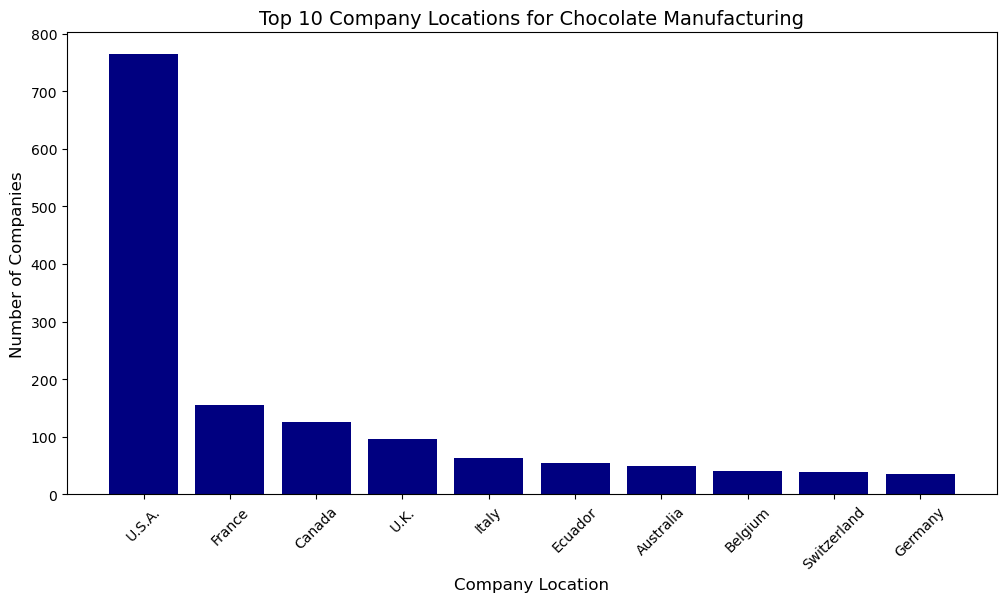

In [13]:
#bar chart
plt.figure(figsize=(12, 6))

plt.bar(top_countries['company_location'], top_countries['count'], color='navy')
plt.title('Top 10 Company Locations for Chocolate Manufacturing', fontsize=14)
plt.xlabel('Company Location', fontsize=12)
plt.ylabel('Number of Companies', fontsize=12)
plt.xticks(rotation=45)
plt.show()

In [14]:
#number of rewviews per year
reviews = chocolate['review_date'].value_counts()
print(reviews)

review_date
2015    285
2014    247
2016    219
2012    195
2013    184
2011    165
2009    123
2010    111
2008     93
2007     77
2006     72
2017     24
Name: count, dtype: int64


In [15]:
#make that into a dateframe with counts
reviews = chocolate['review_date'].value_counts().reset_index()
reviews.columns = ['review_date', 'count']
sorted_reviews = reviews.sort_values(by='review_date', ascending=True)
sorted_reviews.head()

,review_date,count
10,2006,72
9,2007,77
8,2008,93
6,2009,123
7,2010,111


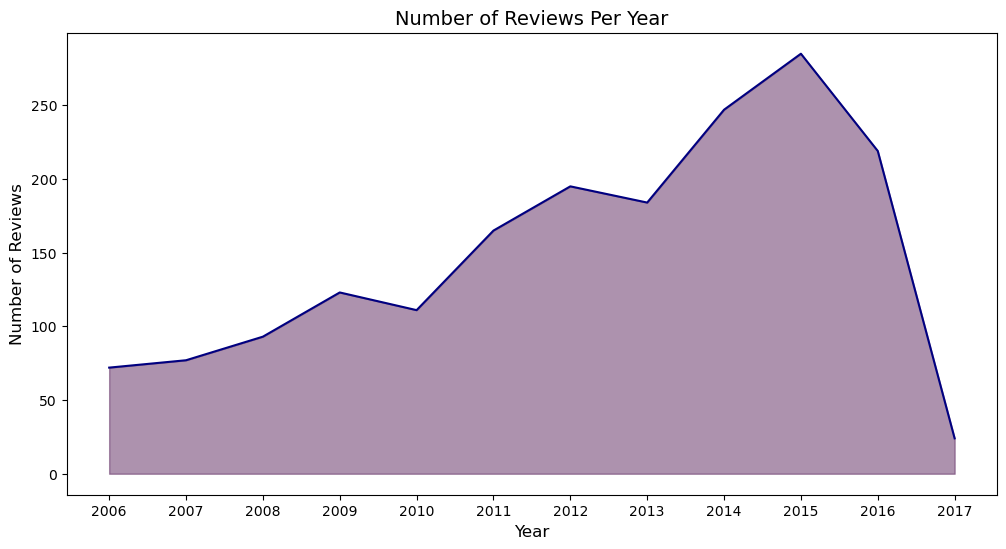

In [19]:
#bar chart to show how many reveiws per year
plt.figure(figsize=(12, 6))
plt.fill_between(sorted_reviews['review_date'], sorted_reviews['count'], color="#5C265F", alpha=0.5)  # Fill the area under the line
plt.plot(sorted_reviews['review_date'], sorted_reviews['count'], color='navy')
plt.title('Number of Reviews Per Year', fontsize=14)
plt.xticks(sorted_reviews['review_date'])
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.show()

In [20]:
#review count by company
company_review = chocolate.groupby(['review_date', 'company_maker'])['review_date'].value_counts()
print(company_review)

review_date  company_maker         
2006         Amedei                    2
             Bonnat                    7
             Cote d' Or (Kraft)        1
             Dolfin (Belcolade)        1
             Domori                    3
                                      ..
2017         Madre                     1
             Smooth Chocolator, The    1
             Soul                      6
             Spencer                   3
             Xocolla                   2
Name: count, Length: 728, dtype: int64


In [21]:
company_review = chocolate.groupby(['company_maker', 'review_date'])['review_date'].value_counts().reset_index()
company_reviews = company_review
company_reviews.head()

,company_maker,review_date,count
0,A. Morin,2012,2
1,A. Morin,2013,11
2,A. Morin,2014,5
3,A. Morin,2015,4
4,A. Morin,2016,1


In [24]:
# Sort Cocoa Percentage for US only
us_chocolate = chocolate[chocolate['company_location'].isin(['U.S.A.'])]


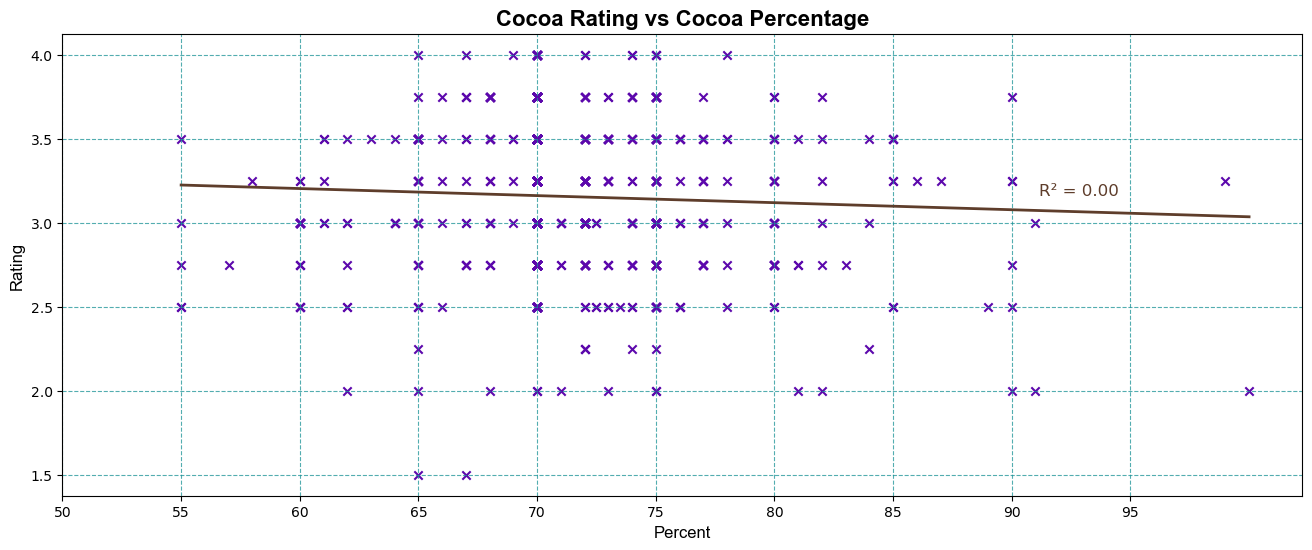

In [47]:

us_chocolate = us_chocolate.sort_values(by='cocoa_percent', ascending=True)
# Build scatter plot for latitude vs. temperature
# make a scatter plot
# Change Canvas Size
plt.figure(figsize=(16, 6))
# Create a basic plot
plt.scatter(us_chocolate.cocoa_percent, us_chocolate.rating, color="#5C08AC", marker="x")

#regression line
slope, intercept, rvalue, pvalue, stderr = linregress(us_chocolate.cocoa_percent, us_chocolate.rating)
regression_line = slope * us_chocolate.cocoa_percent + intercept
plt.plot(us_chocolate.cocoa_percent, regression_line, color="#5E3D2B", linewidth=2, label='Regression Line')
r_squared = rvalue**2
lt.text(0.82, 0.65, f'R² = {r_squared:.2f}', transform=plt.gca().transAxes, fontsize=12, color="#5E3D2B", ha='center')

# Customizations
ticks = np.arange(50, 100, 5)
plt.xticks(ticks)
# Change colors
# Add in reference lines
# Add Labels/Title
plt.xlabel("Percent", fontfamily="Arial", fontsize=12)
plt.ylabel("Rating", fontfamily="Arial", fontsize=12)
plt.title("Cocoa Rating vs Cocoa Percentage", fontweight="bold", fontsize=16, fontfamily="Arial")
# Add in a background grid
plt.grid(linestyle="--", color="#199296", alpha=0.75)
plt.text(0.82, 0.65, f'R² = {r_squared:.2f}', transform=plt.gca().transAxes, fontsize=12, color="#5E3D2B", ha='center')
# Show plot
plt.show()


In [68]:
statistic, p-value = stats.kruskal(ratings, broad_bean_origin, cocoa_percent)
print("Kruskal-Wallis statistic:", statistic)
print("p-value:", p_value)

SyntaxError: cannot assign to expression here. Maybe you meant '==' instead of '='? (2191971310.py, line 1)

In [66]:
chocolate['rating'].mean()

3.185861684327942

In [50]:
print(r_squared)

0.00258451333013808


In [54]:
# Group the data by the categorical variable and collect the ratings
chocolate_grouped = [group["rating"].values for name, group in chocolate.groupby("cocoa_percent")]

# Perform ANOVA
f_statistic, p_value = stats.f_oneway(*chocolate_grouped)

print("F-statistic:", f_statistic)
print("P-value:", p_value)

F-statistic: 5.244577343015249
P-value: 3.9709020055988586e-25


In [65]:
# Group the data by the categorical variable and collect the ratings
chocolate_grouped2 = [group["review_date"].values for name, group in chocolate.groupby("rating")]

# Perform ANOVA
f_statistic, p_value = stats.f_oneway(*chocolate_grouped2)

print("F-statistic:", f_statistic)
print("P-value:", p_value)

F-statistic: 15.568094207280236
P-value: 1.0251506825512328e-31


In [73]:
# Group the data by the categorical variable and collect the ratings
chocolate_grouped3 = [group["rating"].values for name, group in chocolate.groupby("cocoa_percent")]

# Perform ANOVA
f_statistic, p_value = stats.f_oneway(*chocolate_grouped3)

print("F-statistic:", f_statistic)
print("P-value:", p_value)

F-statistic: 5.244577343015249
P-value: 3.9709020055988586e-25
